In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0133

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - loss: 0.0107
Average validation loss: 0.6436647772789001
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - loss: 0.0107 - val_loss: 0.6437
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 908ms/step - loss: 0.0079 - val_loss: 0.6437
Average validation loss: 0.4889848828315735
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 930ms/step - loss: 0.0079 - val_loss: 0.5663
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0059 - val_loss: 0.5663
Average validation loss: 0.3659583330154419
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0059 - val_loss: 0.4995
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 807ms/step - loss: 3.9925e-05
Average validation loss: 0.7413373291492462
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step - loss: 3.9925e-05 - val_loss: 0.7413
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 821ms/step - loss: 3.6872e-05 - val_loss: 0.7413
Average validation loss: 0.1357676014304161
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - loss: 3.6872e-05 - val_loss: 0.4386
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 832ms/step - loss: 3.6882e-05 - val_loss: 0.4386
Average validation loss: 0.09935557097196579
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - loss: 3.6882e-05 - val_loss: 0.3255
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/wei

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - loss: 1.7017e-05
Average validation loss: 0.06577173185845216
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - loss: 1.7017e-05 - val_loss: 0.0658
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 848ms/step - loss: 1.6144e-05 - val_loss: 0.0658
Average validation loss: 0.08791932711998622
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 860ms/step - loss: 1.6144e-05 - val_loss: 0.0768
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 861ms/step - loss: 1.4081e-05 - val_loss: 0.0768
Average validation loss: 0.10642988917728265
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 873ms/step - loss: 1.4081e-05 - val_loss: 0.0867
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 866ms/step - loss: 1.3075e-05 - val_loss: 0.0867
Average validation loss: 0.1063753751417001
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 877ms/step - loss: 1.3075e-05 - val_loss: 0.0916
Epoch 5/10
12/12

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 870ms/step - loss: 4.6275e-06
Average validation loss: 0.05397213948890567
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 881ms/step - loss: 4.6275e-06 - val_loss: 0.0540
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 815ms/step - loss: 3.1362e-06 - val_loss: 0.0540
Average validation loss: 0.09653931856155396
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 825ms/step - loss: 3.1362e-06 - val_loss: 0.0753
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - loss: 2.9222e-06 - val_loss: 0.0753
Average validation loss: 0.015907038061413914
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - loss: 2.9222e-06 - val_loss: 0.0555
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 814ms/step - loss: 2.6473e-06 - val_l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 830ms/step - loss: 4.7822e-06
Average validation loss: 0.082535769790411
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 843ms/step - loss: 4.7822e-06 - val_loss: 0.0825
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - loss: 4.0157e-06 - val_loss: 0.0825
Average validation loss: 0.09809489473700524
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 807ms/step - loss: 4.0157e-06 - val_loss: 0.0903
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 815ms/step - loss: 3.0958e-06 - val_loss: 0.0903
Average validation loss: 0.031087150424718858
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 828ms/step - loss: 3.0958e-06 - val_loss: 0.0706
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 796ms/step - loss: 3.0248e-06 - val_los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 840ms/step - loss: 7.5920e-06
Average validation loss: 0.050086562793391444
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 850ms/step - loss: 7.5920e-06 - val_loss: 0.0501
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - loss: 5.2396e-06 - val_loss: 0.0501
Average validation loss: 0.01329701025194178
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 805ms/step - loss: 5.2396e-06 - val_loss: 0.0317
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 793ms/step - loss: 4.2304e-06 - val_loss: 0.0317
Average validation loss: 0.01193568017333746
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 803ms/step - loss: 4.2304e-06 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 785ms/step - loss: 5.7991e-06
Average validation loss: 0.041952349990606305
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - loss: 5.7991e-06 - val_loss: 0.0420
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 794ms/step - loss: 4.0211e-06 - val_loss: 0.0420
Average validation loss: 0.015587034495547413
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 803ms/step - loss: 4.0211e-06 - val_loss: 0.0288
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 779ms/step - loss: 3.1164e-06 - val_loss: 0.0288
Average validation loss: 0.024195883166976274
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 788ms/step - loss: 3.1164e-06 - val_loss: 0.0272
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 792ms/step - loss: 2.5648e-06 - va

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - loss: 2.7992e-06
Average validation loss: 0.009609465894754976
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - loss: 2.7992e-06 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 802ms/step - loss: 1.9511e-06 - val_loss: 0.0096
Average validation loss: 0.010910309943331717
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 814ms/step - loss: 1.9511e-06 - val_loss: 0.0103
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 793ms/step - loss: 1.5176e-06 - val_loss: 0.0103
Average validation loss: 0.011152826632799892
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 805ms/step - loss: 1.5176e-06 - val_loss: 0.0106
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 798ms/step - loss: 1.3650e-06 - val_loss: 0.0106
Average validation loss: 0.010857985830322528
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 810ms/step - loss: 1.3650e-06 - val_loss: 0.0106
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 802ms/step - loss: 1.8897e-06
Average validation loss: 0.05980558241052287
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - loss: 1.8897e-06 - val_loss: 0.0598
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 861ms/step - loss: 1.4949e-06 - val_loss: 0.0598
Average validation loss: 0.012120643414423935
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 872ms/step - loss: 1.4949e-06 - val_loss: 0.0360
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 854ms/step - loss: 1.2006e-06 - val_loss: 0.0360
Average validation loss: 0.01269162306562066
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 865ms/step - loss: 1.2006e-06 - val_loss: 0.0282
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 815ms/step - loss: 1.0402e-06 - va

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 808ms/step - loss: 1.0371e-06
Average validation loss: 0.014075066457735375
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 819ms/step - loss: 1.0371e-06 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 795ms/step - loss: 7.9690e-07 - val_loss: 0.0141
Average validation loss: 0.012318072229390964
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 807ms/step - loss: 7.9690e-07 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 790ms/step - loss: 7.1862e-07 - val_loss: 0.0132
Average validation loss: 0.012050594144966453
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 801ms/step - loss: 7.1862e-07 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weight

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 8.6333e-07
Average validation loss: 0.013041899888776243
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 803ms/step - loss: 8.6333e-07 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 8.3532e-07 - val_loss: 0.0130
Average validation loss: 0.013011941615129925
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 8.3532e-07 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 791ms/step - loss: 6.6651e-07 - val_loss: 0.0130
Average validation loss: 0.014572711878119864
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 802ms/step - loss: 6.6651e-07 - val_loss: 0.0135
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 5.6259e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 792ms/step - loss: 6.0191e-07
Average validation loss: 0.016309830424143003
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 6.0191e-07 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 822ms/step - loss: 5.1902e-07 - val_loss: 0.0163
Average validation loss: 0.007716351325507275
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 833ms/step - loss: 5.1902e-07 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 802ms/step - loss: 4.2415e-07 - val_loss: 0.0120
Average validation loss: 0.012708466697949916
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 813ms/step - loss: 4.2415e-07 - val_loss: 0.0122
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 813ms/step - loss: 4.1772e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 804ms/step - loss: 1.4952e-06
Average validation loss: 0.017374808725435287
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 815ms/step - loss: 1.4952e-06 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 774ms/step - loss: 1.2419e-06 - val_loss: 0.0174
Average validation loss: 0.015682686265790835
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 785ms/step - loss: 1.2419e-06 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 804ms/step - loss: 1.1020e-06 - val_loss: 0.0165
Average validation loss: 0.02122849115403369
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 815ms/step - loss: 1.1020e-06 - val_loss: 0.0181
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 810ms/step - loss: 9.5257e-07

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 2.8854e-06
Average validation loss: 0.02552118900542458
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 805ms/step - loss: 2.8854e-06 - val_loss: 0.0255
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 802ms/step - loss: 2.4424e-06 - val_loss: 0.0255
Average validation loss: 0.012381815700791776
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 813ms/step - loss: 2.4424e-06 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 805ms/step - loss: 1.8939e-06 - val_loss: 0.0190
Average validation loss: 0.014666163661361982
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 816ms/step - loss: 1.8939e-06 - val_loss: 0.0175
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 387s 792ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 796ms/step - loss: 1.8443e-06
Average validation loss: 0.011527768905378051
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 807ms/step - loss: 1.8443e-06 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 793ms/step - loss: 1.3204e-06 - val_loss: 0.0115
Average validation loss: 0.009605742187381515
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 803ms/step - loss: 1.3204e-06 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 791ms/step - loss: 1.0950e-06 - val_loss: 0.0106
Average validation loss: 0.02058538652232124
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 802ms/step - loss: 1.0950e-06 - val_loss: 0.0139
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 462s 794ms/step - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 789ms/step - loss: 8.2656e-07
Average validation loss: 0.018592705781338738
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 800ms/step - loss: 8.2656e-07 - val_loss: 0.0186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 254s 784ms/step - loss: 6.3761e-07 - val_loss: 0.0186
Average validation loss: 0.011597572395112365
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 795ms/step - loss: 6.3761e-07 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 792ms/step - loss: 5.7870e-07 - val_loss: 0.0151
Average validation loss: 0.013554796273820103
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 803ms/step - loss: 5.7870e-07 - val_loss: 0.0146
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 513s 807ms/step -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 795ms/step - loss: 9.5342e-07
Average validation loss: 0.016444602436386048
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 806ms/step - loss: 9.5342e-07 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 795ms/step - loss: 7.0556e-07 - val_loss: 0.0164
Average validation loss: 0.015026938589289784
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 806ms/step - loss: 7.0556e-07 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 483s 805ms/step - loss: 5.7996e-07 - val_loss: 0.0157
Average validation loss: 0.014047910021618008
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 815ms/step - loss: 5.7996e-07 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetectio

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - loss: 7.6126e-07
Average validation loss: 0.02206386822654167
240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 801ms/step - loss: 7.6126e-07 - val_loss: 0.0221
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 783ms/step - loss: 6.1177e-07 - val_loss: 0.0221
Average validation loss: 0.012424777877822635
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 794ms/step - loss: 6.1177e-07 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 573s 792ms/step - loss: 5.4206e-07 - val_loss: 0.0172
Average validation loss: 0.015562477325511281
240/240 ━━━━━━━━━━━━━━━━━━━━ 575s 803ms/step - loss: 5.4206e-07 - val_loss: 0.0167
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 767s 796ms/step - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.23802097760140895, 0.16434791278094052, 0.07713181879371406, 0.07436887048534117, 0.038754051471361885, 0.014607365395252902, 0.03220761514466722, 0.020874538394079233, 0.012886653758801657, 0.010632440077897628, 0.00957489764602441, 0.008772208375914487, 0.014060605038054444, 0.014509740348905327, 0.016903662115771677, 0.014726333125532618, 0.015994762856071792, 0.015162217329143458]
std_val_losses =  [0.16037902935930437, 0.19417468694795956, 0.06668041688496323, 0.13273408163441, 0.04470654177040698, 0.008993473333458743, 0.03524266311958929, 0.018158842926039406, 0.01242903943180988, 0.004351846698254309, 0.002871638599418233, 0.0036486630165139516, 0.009705546827737834, 0.004319415754837313, 0.005615493881313468, 0.004351768957259042, 0.0027395806494569705, 0.0037276477048418318]


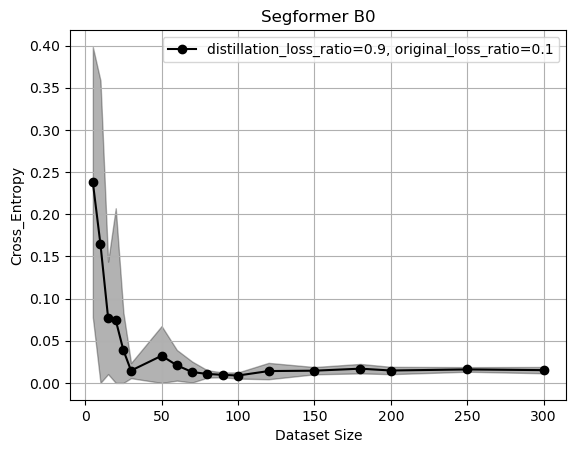

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()